<a href="https://colab.research.google.com/github/drawnator/PLN-grupo-19/blob/main/Grupo8_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ferramenta Otimizadora De Aleatoriedade em senhas
---
Modelo de linguagem que auxilia a tornar senhas mais fortes, com base em critérios de fortificação de senhas como o [zxcvbn](https://github.com/dropbox/zxcvbn) e em [senhas vazadas da plataforma rockyou](https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt).

A aplicação prática do modelo é analisar a senha de entrada, identificar se ela é fraca ou forte segundo critérios predefinidos, se é uma senha comum (presentes na base de dados de senhas vazadas) ou não, e, por fim, dar sugestões pontuais de como tornar a senha mais improvável de adivinhar.

Assuntos:
- Análise de frequência
- Masked language model

Tecnologias utilizadas:
- RNN
- Árvores de decisão
- ZXCVBN
- Bert?
- tsne?
- Princípios de senha aleatória

##Preparando o ambiente de execução (imports necessários)

In [ ]:
!pip install zxcvbn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.2 MB/s eta 0:00:00


In [ ]:
import requests
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, SimpleRNN
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.utils import Sequence

import matplotlib.pyplot as plt
from google.colab import drive
import pickle

In [ ]:
from zxcvbn import zxcvbn

In [ ]:
# from transformers import DistilBertTokenizer, TFDistilBertForMaskedLM
# from transformers import BertTokenizer
# from transformers import TFDistilBertForSequenceClassification

In [ ]:
import tqdm

## Preparando os dados

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = "rockyou.txt"
path = '/content/drive/MyDrive/my_models/rockyout.txt'


Mounted at /content/drive


In [ ]:
# RECOMENDO FORTEMENTE BAIXAR E ARRASTAR MANUALMENTE ATÉ ARTIGOS, ISSO AQUI DEMORA MT \/
url = "https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt"
#download from github using wget
!wget {url} -O rockyou.txt

--2025-09-23 13:51:24--  https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/97553311/d4f580f8-6b49-11e7-8f70-7f460f85ab3a?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-23T14%3A39%3A16Z&rscd=attachment%3B+filename%3Drockyou.txt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-23T13%3A39%3A05Z&ske=2025-09-23T14%3A39%3A16Z&sks=b&skv=2018-11-09&sig=t%2FrkmACCWT%2BxLoA0fAXBatmsPeJWgwkAjKr7fuOr7pM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODYzNTc4NCwibmJmIjoxNzU4NjM1NDg0LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ib

In [ ]:
with open("rockyou.txt", "r", encoding='latin-1') as f:
  df = pd.DataFrame(f.readlines(), columns=['password'])

In [ ]:
df['password'] = df['password'].str.replace('\n', '')

In [ ]:
# if not os.path.exists("rockyou.csv"):
#   df.to_csv("rockyou.csv")

In [ ]:
df = df[df['password'].str.len() > 1]
display(df.shape)

(14344345, 1)

In [ ]:
df.shape

(14344391, 1)

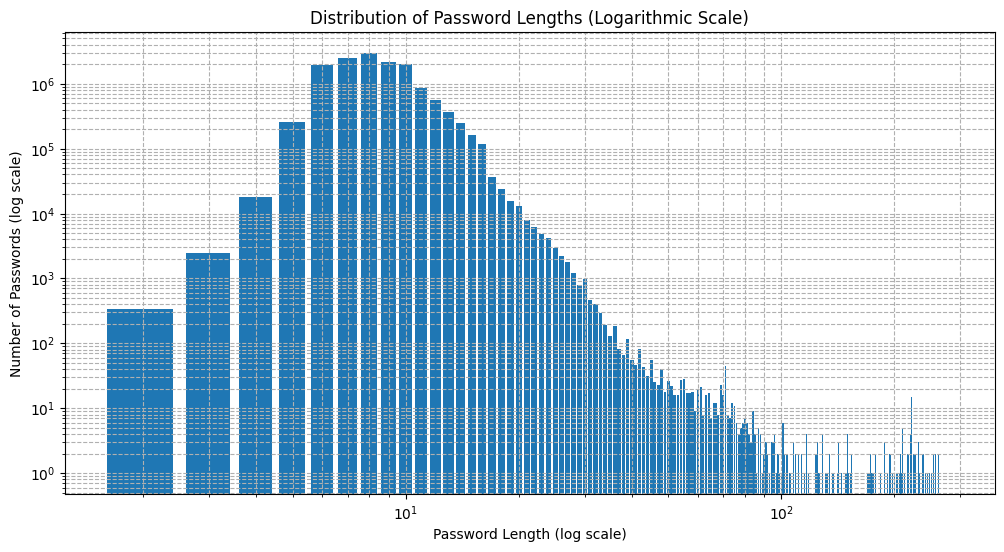

In [ ]:
df['password_length'] = df['password'].str.len()

length_counts = df['password_length'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(length_counts.index, length_counts.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Password Length (log scale)')
plt.ylabel('Number of Passwords (log scale)')
plt.title('Distribution of Password Lengths (Logarithmic Scale)')
plt.grid(True, which="both", ls="--")
plt.show()

# Métodos de avaliar a qualidade de uma senha

# RNN

Previsibilidade de caracteres, com base em uma parte da senha o quão fácil é prever o resto dela?


## Tokenização

Transformando os caracteres de uma senha em tokens para que eles estejam no formato adequado para o processamento.

In [ ]:
all_chars = sorted(list(set(''.join(df['password']))))
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

In [ ]:
char_to_int['[MASK]'] = len(char_to_int)
char_to_int['[CLS]'] = len(char_to_int)
char_to_int['[SEP]'] = len(char_to_int)
char_to_int['[PAD]'] = len(char_to_int)
int_to_char = {i: char for char, i in char_to_int.items()}

In [ ]:
class RNNTokenizer():
  def __init__(self, char_to_int,int_to_char,max_length = 32):
    self.char_to_int = char_to_int
    self.int_to_char = int_to_char
    self.mask_token_id = char_to_int['[MASK]']
    self.cls_token_id = char_to_int['[CLS]']
    self.sep_token_id = char_to_int['[SEP]']
    self.pad_token_id = char_to_int['[PAD]']
    self.max_length = max_length
    self.vocab_size = len(char_to_int)

  def __call__(self,text):
    token = [self.pad_token_id] * self.max_length
    text = f"{text:>{self.max_length}}"
    # print(text)
    for i in range(self.max_length):
      token[-i] = char_to_int[text[-i]]

    # for i in range(self.max_length):
    #   if (i < len(text)):
    #     token.append(char_to_int[text[i]])
    #   else:
    #     token.append(char_to_int['[PAD]'])

    return token

In [ ]:
rnntokenizer = RNNTokenizer(char_to_int,int_to_char)

In [ ]:
class RNNDataloader(Sequence):
  def __init__(self,dataframe,tokenizer,batch_size=100):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def mask_and_tokens(self,password):
      i = np.random.randint(1, min(len(password),self.tokenizer.max_length))
      label = self.tokenizer.char_to_int[password[i]]
      input_seq = self.tokenizer(password[:i])

      # input_seq += [self.tokenizer.mask_token_id]
      # input_seq += [self.tokenizer.pad_token_id] * (self.tokenizer.max_length - len(input_seq))
      return input_seq,label

  def __len__(self):
    return len(self.dataframe) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_inputs = []
    batch_labels = []
    for password in batch:
      input_seq, label = self.mask_and_tokens(password)
      batch_inputs.append(input_seq)
      batch_labels.append(label)
    return np.array(batch_inputs), np.array(batch_labels)

In [ ]:
dataloader = RNNDataloader(df['password'],rnntokenizer)

In [ ]:
df["password"][0]

'123456'

In [ ]:
dataloader[0]

(array([[ 4,  4,  4, ..., 23, 24, 25],
        [ 4,  4,  4, ..., 22, 23, 24],
        [ 4,  4,  4, ...,  4,  4, 21],
        ...,
        [ 4,  4,  4, ...,  4, 80, 69],
        [ 4,  4,  4, ..., 71, 79, 73],
        [ 4,  4,  4, ...,  4,  4, 84]]),
 array([26, 25, 22, 87, 90, 87, 26, 79, 26, 22, 71, 80, 69, 79, 83, 73, 22,
        73, 87, 91, 21, 80, 20, 73, 75, 73, 80, 21, 73, 82, 82, 89, 84, 80,
        86, 77, 82, 90, 71, 22, 80, 88, 69, 86, 73, 87, 89, 24, 84, 82, 81,
        93, 86, 69, 86, 82, 88, 86, 93, 80, 69, 73, 80, 73, 76, 77, 73, 87,
        69, 77, 82, 26, 91, 77, 73, 76, 70, 73, 73, 93, 82, 23, 88, 73, 75,
        87, 73, 69, 81, 91, 75, 84, 77, 83, 69, 83, 69, 89, 93, 86]))

In [ ]:
# drive.mount('/content/drive')

# char_to_int = '/content/drive/MyDrive/my_models/char_to_int.pkl'
# int_to_char = '/content/drive/MyDrive/my_models/int_to_char.pkl'

# with open(char_to_int, 'wb') as f:
#     pickle.dump(char_to_int, f)

# with open(int_to_char, 'wb') as f:
#     pickle.dump(int_to_char, f)

In [ ]:
# drive.mount('/content/drive')
# with open(char_to_int, 'rb') as f:
#     char_to_int = pickle.load(f)

# with open(int_to_char, 'rb') as f:
#     int_to_char = pickle.load(f)

## Dividindo os dados em conjuntos de treino, validação e teste

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_train_val_test_arrays(df, dataloader, tokenizer, test_size=0.2, val_size=0.5,):
    train_df, temp_df = train_test_split(df, test_size=test_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=42)

    train_dataloader = dataloader(train_df, tokenizer,batch_size=1000)
    val_dataloader = dataloader(val_df, tokenizer,batch_size=1000)
    test_dataloader = dataloader(test_df, tokenizer,batch_size=1000)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader,val_dataloader,test_dataloader = create_train_val_test_arrays(df["password"], RNNDataloader, rnntokenizer)

## Definindo o modelo

### training model

In [ ]:
#https://colab.research.google.com/drive/1mts5E3yAd1irLzS7Ei6UtwbG773C87DB?usp=sharing
model = Sequential([
    Embedding(
        input_dim=rnntokenizer.vocab_size,
        output_dim=100,
        input_shape=(rnntokenizer.max_length,)),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(128, activation='relu'),
    Dense(rnntokenizer.vocab_size, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 32, 100)        │        21,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 128)        │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 218)            │        28,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,086 (539.40 KB)

 Trainable params: 138,086 (539.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataloader,
    validation_data=(val_dataloader),
    epochs=5,
    batch_size=128,#256
    verbose=1)

Epoch 1/5
11475/11475 ━━━━━━━━━━━━━━━━━━━━ 215s 17ms/step - accuracy: 0.1511 - loss: 2.9189 - val_accuracy: 0.1826 - val_loss: 2.7564
Epoch 2/5
11475/11475 ━━━━━━━━━━━━━━━━━━━━ 194s 17ms/step - accuracy: 0.1783 - loss: 2.7795 - val_accuracy: 0.1914 - val_loss: 2.7301
Epoch 3/5
11475/11475 ━━━━━━━━━━━━━━━━━━━━ 195s 17ms/step - accuracy: 0.1832 - loss: 2.7618 - val_accuracy: 0.1937 - val_loss: 2.7201
Epoch 4/5
11475/11475 ━━━━━━━━━━━━━━━━━━━━ 193s 17ms/step - accuracy: 0.1859 - loss: 2.7523 - val_accuracy: 0.1963 - val_loss: 2.7137
Epoch 5/5
11475/11475 ━━━━━━━━━━━━━━━━━━━━ 195s 17ms/step - accuracy: 0.1873 - loss: 2.7487 - val_accuracy: 0.1973 - val_loss: 2.7086


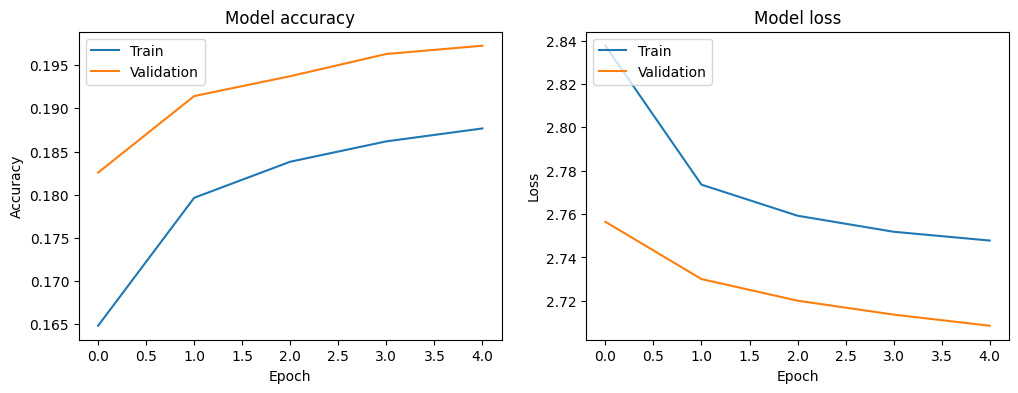

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/my_models/rnn_password_model5.keras'

import os
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model.save(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### load model

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')

model_load_path = '/content/drive/MyDrive/my_models/rnn_password_model5.keras'

model = tf.keras.models.load_model(model_load_path)
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 32, 100)        │        21,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 128)        │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 218)            │        28,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,260 (1.58 MB)

 Trainable params: 138,086 (539.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,174 (1.05 MB)

## métricas de modelo

In [ ]:
class RnnMetrics():
  def __init__(self,model:tf.keras.models.Model,tokenizer:RNNTokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def preencher_senha(self,senha_base):
    while len(senha_base) < self.tokenizer.max_length:
      senha_base += self.prever_proxima(senha_base)
    return senha_base

  def prever_proxima(self,palavras):
      seq = self.tokenizer(palavras)
      seq = np.array([seq])
      pred = self.model.predict(seq, verbose=0)
      idx = np.argmax(pred)
      return self.tokenizer.int_to_char[idx]

  def get_probs(self,palavra,temperatura=1.0):
    seq = self.tokenizer(palavra)
    seq = np.array([seq])
    pred = self.model.predict(seq, verbose=0)
    logits = np.log(pred + 1e-9) / temperatura  # evita log(0)
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    return probs

  def get_char_rarity(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    smaller_than = np.where(probs < probs[0][char_token])[0]
    return smaller_than.shape[0]/self.tokenizer.vocab_size

  def get_rarity(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_rarity(probs,password[part]))
    return rarity

  def get_char_proportional_probability(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    return probs[0][char_token]

  def get_proportional_probability(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_proportional_probability(probs,password[part]))
    return rarity

  def get_weighted_scores(self,password,weight=[1,1]):
    rarity = self.get_rarity(password)
    proportional_probability = self.get_proportional_probability(password)
    return (np.array(rarity) * weight[0] + np.array(proportional_probability) * weight[1])/sum(weight)

  def get_rarer_alternatives(self,password):
    probs = self.get_probs(password[:len(password)])
    rarer_alternatives = np.where(probs[0] < probs[0][self.tokenizer.char_to_int[password[-1]]])[0]
    return [self.tokenizer.int_to_char[i] for i in rarer_alternatives]



In [ ]:
rnnmetrics = RnnMetrics(model,rnntokenizer)

In [ ]:
rnnmetrics.get_probs("i")

array([[1.08030840e-09, 1.04474074e-09, 1.56272173e-09, 1.05537967e-09,
        5.79822157e-03, 7.94337320e-05, 3.31804131e-06, 5.12165279e-05,
        3.97258264e-05, 4.56319867e-06, 1.88971389e-04, 1.41202332e-03,
        3.63322499e-04, 1.20018994e-05, 2.14432235e-04, 6.29841816e-05,
        3.54117190e-04, 1.45795697e-03, 5.19600522e-04, 4.83369004e-05,
        2.50756950e-03, 4.36841697e-03, 2.95648212e-03, 1.55284780e-03,
        1.45132933e-03, 1.48592144e-03, 1.00157002e-03, 1.31850224e-03,
        2.17932905e-03, 1.86198123e-03, 1.25297420e-05, 1.59969015e-04,
        3.44992289e-03, 7.55860674e-05, 4.90362982e-06, 3.74380943e-05,
        1.73919674e-04, 3.52854404e-05, 3.40277475e-05, 3.12613738e-05,
        1.98847574e-05, 1.59260344e-05, 1.19928363e-05, 3.02171738e-05,
        5.80527521e-05, 7.49263290e-06, 1.87008009e-05, 4.31767476e-05,
        3.57164565e-04, 9.62542472e-05, 8.11075661e-05, 2.27743221e-05,
        2.83010722e-05, 1.04499686e-05, 7.47304730e-05, 5.417116

In [ ]:
rnnmetrics.preencher_senha("passwo")

'password123456799100000070303030'

In [ ]:
rnnmetrics.get_proportional_probability("password12345")

[np.float32(0.03674563),
 np.float32(0.22743146),
 np.float32(0.068196245),
 np.float32(0.3655133),
 np.float32(0.015787784),
 np.float32(0.13803862),
 np.float32(0.44022638),
 np.float32(0.47404578),
 np.float32(0.14415048),
 np.float32(0.21190882),
 np.float32(0.7315842),
 np.float32(0.8053402),
 np.float32(0.94908816)]

### visualizar métricas do modelo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_heatmap(password, scores):
    heatmap_data = np.array(scores).reshape(1, -1)

    plt.figure(figsize=(len(password) * 0.5, 1))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=1)
    plt.colorbar(label='Score (0-1)')

    for i in range(len(password)):
        plt.text(i, 0, password[i], ha='center', va='center', color='white' if heatmap_data[0, i] < 0.5 else 'black')

    plt.title(f"{password}")
    plt.yticks([])
    plt.xticks([])
    plt.show()


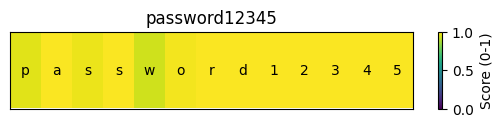

0.984121383203952


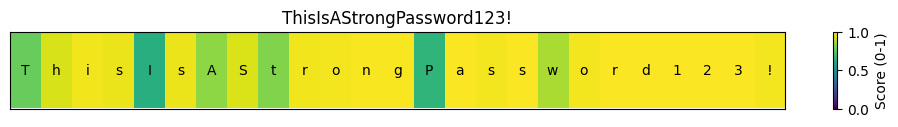

0.9289908256880735


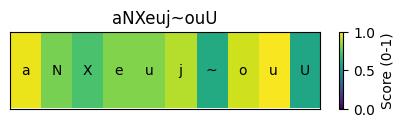

0.8105504587155963


In [ ]:
password = "password12345"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "ThisIsAStrongPassword123!"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "aNXeuj~ouU"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

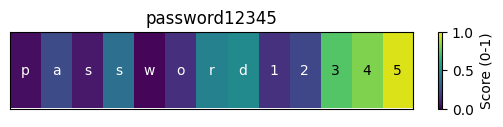

0.35446593


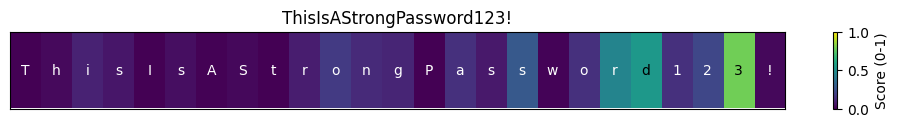

0.13993783


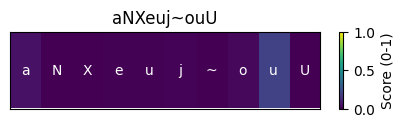

0.028985303


In [ ]:
password = "password12345"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))

password = "ThisIsAStrongPassword123!"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


password = "aNXeuj~ouU"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


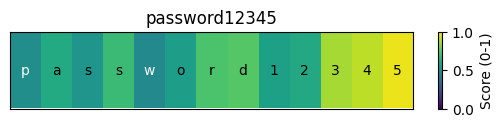

0.6692936436740461


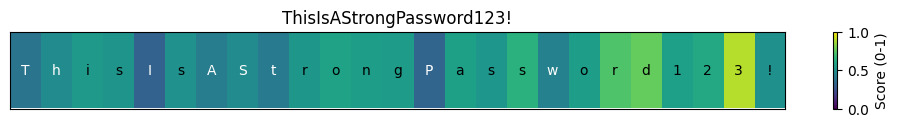

0.5344643276668575


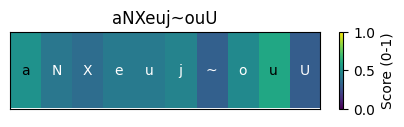

0.4197678810817564


In [ ]:
password = "password12345"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "ThisIsAStrongPassword123!"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "aNXeuj~ouU"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

# Bert

## tokenização


In [ ]:
berttokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-cased',
    # do_basic_tokenize=False,
    # do_lower_case=False,
    # split_special_tokens=True,
    )
seq_length = 32

In [ ]:
token = berttokenizer("aNXeuj~ouU",
                      padding='max_length',
                      truncation=True,
                      max_length=seq_length,
                      split_special_tokens=True
                      )
token

In [ ]:
# Example of decoding each token individually
decoded_tokens = [berttokenizer.decode([token_id]) for token_id in token['input_ids']]
print(decoded_tokens)

In [ ]:
class BertDataloader(Sequence):
  def __init__(self,dataframe,tokenizer,seq_length=32,batch_size=100):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.seq_length = seq_length

  def mask_and_tokens(self,password):
      token = self.tokenizer(password,
                              padding='max_length',
                              truncation=True,
                              max_length=self.seq_length,
                              split_special_tokens=True
                              )
      sep_index = token['input_ids'].index(self.tokenizer.sep_token_id)
      i = np.random.randint(1, sep_index)

      label = np.full(self.seq_length, 0, dtype=np.int32)
      label[i] = token['input_ids'][i]
      token['input_ids'][i] = self.tokenizer.mask_token_id

      return token,label

  def __len__(self):
    return len(self.dataframe) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_inputs = {'input_ids': [], 'attention_mask': []}
    batch_labels = []
    for password in batch:
      input_seq, label = self.mask_and_tokens(password)
      batch_inputs['input_ids'].append(input_seq['input_ids'])
      batch_inputs['attention_mask'].append(input_seq['attention_mask'])
      batch_labels.append(label)

    # Convert lists to TensorFlow tensors
    batch_inputs['input_ids'] = tf.constant(batch_inputs['input_ids'], dtype=tf.int32)
    batch_inputs['attention_mask'] = tf.constant(batch_inputs['attention_mask'], dtype=tf.int32)
    batch_labels = tf.constant(batch_labels, dtype=tf.int32)

    return batch_inputs, batch_labels

In [ ]:
def create_bert_dataset(dataframe, tokenizer, seq_length, batch_size):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for password in tqdm.tqdm(dataframe):
      token = tokenizer(password,
                        padding='max_length',
                        truncation=True,
                        max_length=seq_length,
                        split_special_tokens=True
                        )

      sep_index = token['input_ids'].index(tokenizer.sep_token_id)
      if sep_index > 1:
          i = np.random.randint(1, sep_index)
      else:
            continue

      label = np.full(seq_length, -100, dtype=np.int32) #uhoh...
      label[i] = token['input_ids'][i]
      token['input_ids'][i] = tokenizer.mask_token_id

      input_ids_list.append(token['input_ids'])
      attention_mask_list.append(token['attention_mask'])
      labels_list.append(label)

    input_ids_tensor = tf.constant(input_ids_list, dtype=tf.int32)
    attention_mask_tensor = tf.constant(attention_mask_list, dtype=tf.int32)
    labels_tensor = tf.constant(labels_list, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids_tensor,
                                                   'attention_mask': attention_mask_tensor},
                                                  labels_tensor))

    dataset = dataset.shuffle(buffer_size=len(input_ids_list)).batch(batch_size)

    return dataset

## Dividindo os dados em conjuntos de treino, validação e teste

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_train_val_test_arrays(df, dataloader, tokenizer, test_size=0.2, val_size=0.5,):
    train_df, temp_df = train_test_split(df, test_size=test_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=42)

    train_dataloader = dataloader(train_df, tokenizer,batch_size=1000)
    val_dataloader = dataloader(val_df, tokenizer,batch_size=1000)
    test_dataloader = dataloader(test_df, tokenizer,batch_size=1000)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader,val_dataloader,test_dataloader = create_train_val_test_arrays(df["password"], BertDataloader, berttokenizer)

In [ ]:
print(df['password'][0])
token,labels = train_dataloader[0]

In [ ]:
token

In [ ]:
train_df, temp_df = train_test_split(df['password'], test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_dataset = create_bert_dataset(train_df, berttokenizer, seq_length, batch_size=100)
val_dataset = create_bert_dataset(val_df, berttokenizer, seq_length, batch_size=100)
test_dataset = create_bert_dataset(test_df, berttokenizer, seq_length, batch_size=100)

## Modelo

In [ ]:
model = TFDistilBertForMaskedLM.from_pretrained('distilbert-base-cased', from_pt=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    )

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model in your Google Drive
# You might want to change 'bert_password_model' to a specific name
model_save_path = '/content/drive/MyDrive/my_models/bert_password_model'

# Create the directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the model and tokenizer
# Use save_pretrained for Hugging Face models
model.save_pretrained(model_save_path)
berttokenizer.save_pretrained(model_save_path)

print(f"BERT model and tokenizer saved to: {model_save_path}")

## Métricas

In [ ]:
def evaluate_password_with_bert(password, model, tokenizer, seq_length=32):
    tokenized_password = tokenizer(password,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=seq_length,
                                   return_tensors='tf',
                                   split_special_tokens=True
                                  )

    input_ids = tokenized_password['input_ids']
    attention_mask = tokenized_password['attention_mask']
    sep_index = tf.where(input_ids == tokenizer.sep_token_id)[0][1].numpy()

    if sep_index <= 1:
        print("Password too short to mask a meaningful token.")
        return None

    probabilities = []
    for mask_index in range(1, sep_index):

        original_token_id = input_ids[0, mask_index].numpy()
        original_token = tokenizer.decode([original_token_id])

        masked_input_ids = tf.identity(input_ids)
        masked_input_ids = tf.tensor_scatter_nd_update(masked_input_ids, [[0, mask_index]], [tokenizer.mask_token_id])

        predictions = model({'input_ids': masked_input_ids, 'attention_mask': attention_mask})
        masked_token_logits = predictions.logits[0, mask_index, :]

        probs = tf.nn.softmax(masked_token_logits).numpy()

        probability_of_original_token = probs[original_token_id]
        probabilities.append(probability_of_original_token)

        print(f"Masked token at index {mask_index}: '{original_token}' (ID: {original_token_id}) - Probability: {probability_of_original_token:.4f}")


    return probabilities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bert_probability_heatmap(password, probabilities, tokenizer, seq_length=32):
    tokenized_password = tokenizer(password,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=seq_length,
                                   split_special_tokens=True
                                  )
    input_ids = tokenized_password['input_ids']
    tokens = [tokenizer.decode([token_id]) for token_id in input_ids]


    sep_index = input_ids.index(tokenizer.sep_token_id)
    display_tokens = tokens[1:sep_index]
    display_probabilities = probabilities


    if not display_tokens:
        print("No tokens to display.")
        return

    heatmap_data = np.array(display_probabilities).reshape(1, -1)

    plt.figure(figsize=(len(display_tokens) * 0.7, 2))
    plt.imshow(heatmap_data, cmap='viridis_r', aspect='auto', vmin=0.0, vmax=1.0)
    plt.colorbar(label='Probability of Original Token (0-1)')

    for i in range(len(display_tokens)):
        text_color = 'white' if heatmap_data[0, i] < 0.5 else 'black'
        plt.text(i, 0, display_tokens[i], ha='center', va='center', color=text_color, fontsize=10)

    plt.title(f"BERT Probability Heatmap for: {password}")
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
user_password = "password123"
average_prob = evaluate_password_with_bert(user_password, model, berttokenizer, seq_length)
plot_bert_probability_heatmap(user_password, average_prob, berttokenizer, seq_length)

user_password = "aNXeuj~ouU"
average_prob = evaluate_password_with_bert(user_password, model, berttokenizer, seq_length)
plot_bert_probability_heatmap(user_password, average_prob, berttokenizer, seq_length)

user_password = "ThisIsAStrongPassword123!"
average_prob = evaluate_password_with_bert(user_password, model, berttokenizer, seq_length)
plot_bert_probability_heatmap(user_password, average_prob, berttokenizer, seq_length)

# ZXCVBN

In [ ]:
def zxcvbneficar(senhas):
  for s in senhas:
    resultado = zxcvbn(s)
    print(resultado)
    print(f"Senha: {s}")
    print(f"  - Pontuação (0 a 4): {resultado['score']}")
    print(f"  - Feedback: {resultado['feedback']['warning'] or 'Nenhum aviso'}")
    print(f"  - Sugestões: {resultado['feedback']['suggestions'] or 'Nenhuma'}")
    print(f"  - Tempo de quebra: {resultado['crack_times_display']['offline_fast_hashing_1e10_per_second']}")
    print("--------------------------------------------------------------------------------------------------")


senhas = [
    "password12345",
    "ThisIsAStrongPassword123!",
    "aNXeuj~ouU"
]

zxcvbneficar(senhas)

{'password': 'password12345', 'guesses': Decimal('15000'), 'guesses_log10': 4.176091259055681, 'sequence': [{'pattern': 'dictionary', 'i': 0, 'j': 7, 'token': 'password', 'matched_word': 'password', 'rank': 2, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 2, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}, {'pattern': 'dictionary', 'i': 8, 'j': 12, 'token': '12345', 'matched_word': '12345', 'rank': 6, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 6, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}], 'calc_time': datetime.timedelta(microseconds=6969), 'crack_times_seconds': {'online_throttling_100_per_hour': Decimal('540000.0000000000299760216649'), 'online_no_throttling_10_per_second': Decimal('1500'), 'offline_slow_hashing_1e4_per_second': Decimal('1.5'), 'offline_fast_hashing_1e10_per_second': Decimal('0.00000

In [ ]:
for senha in senhas:
  print(senha)
  resultado = zxcvbn(senha)
  for atributo in resultado:
    print(atributo,resultado[atributo])

password12345
password password12345
guesses 15000
guesses_log10 4.176091259055681
sequence [{'pattern': 'dictionary', 'i': 0, 'j': 7, 'token': 'password', 'matched_word': 'password', 'rank': 2, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 2, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}, {'pattern': 'dictionary', 'i': 8, 'j': 12, 'token': '12345', 'matched_word': '12345', 'rank': 6, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 6, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}]
calc_time 0:00:00.004090
crack_times_seconds {'online_throttling_100_per_hour': Decimal('540000.0000000000299760216649'), 'online_no_throttling_10_per_second': Decimal('1500'), 'offline_slow_hashing_1e4_per_second': Decimal('1.5'), 'offline_fast_hashing_1e10_per_second': Decimal('0.0000015')}
crack_times_display {'online_throttling_

In [ ]:
for senha in senhas:
  print(senha)
  resultado = zxcvbn(senha)
  for sequence in resultado["sequence"]:
    print(sequence)

password12345
{'pattern': 'dictionary', 'i': 0, 'j': 7, 'token': 'password', 'matched_word': 'password', 'rank': 2, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 2, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}
{'pattern': 'dictionary', 'i': 8, 'j': 12, 'token': '12345', 'matched_word': '12345', 'rank': 6, 'dictionary_name': 'passwords', 'reversed': False, 'l33t': False, 'base_guesses': 6, 'uppercase_variations': 1, 'l33t_variations': 1, 'guesses': 50, 'guesses_log10': 1.6989700043360185}
ThisIsAStrongPassword123!
{'pattern': 'bruteforce', 'token': 'ThisIsA', 'i': 0, 'j': 6, 'guesses': 10000000, 'guesses_log10': 7.0}
{'pattern': 'dictionary', 'i': 7, 'j': 12, 'token': 'Strong', 'matched_word': 'strong', 'rank': 570, 'dictionary_name': 'surnames', 'reversed': False, 'l33t': False, 'base_guesses': 570, 'uppercase_variations': 2, 'l33t_variations': 1, 'guesses': 1140, 'guesses_log10': 3.056904851336

# iterativamente fazendo uma senha melhor

In [ ]:
import string

In [ ]:
possible_characters = list(string.ascii_letters + string.digits + string.punctuation)

In [ ]:
def make_better_password(password, metric, tokenizer, seq_length=32):
  result = zxcvbn(password)
  while result['score'] < 4:
    score = metric.get_weighted_scores(password,weight=[1,1])
    modified = False
    for sequence in result["sequence"]:
      print("found:",sequence["token"],"with",sequence['pattern'])
      if sequence['pattern'] in ['dictionary','repeat']:
        string = sequence['token']
        first_char_pos = password.find(string)
        last_char_pos = first_char_pos + len(string)
        best = np.argmax(score[first_char_pos:last_char_pos])
        best_position = first_char_pos + best
        alternatives = metric.get_rarer_alternatives(password[:best_position])
        alternatives = [a for a in alternatives if a in possible_characters]
        if alternatives:
          modified = True
          password = password[:best_position] + np.random.choice(alternatives) + password[best_position+1:]
      else:
        probs = metric.get_probs(password)[0]
        possible_characters_score = []
        for character in possible_characters:
          possible_characters_score.append(1-probs[tokenizer.char_to_int[character]])
        possible_characters_score = np.array(possible_characters_score)
        possible_characters_score = possible_characters_score / possible_characters_score.sum()
        password += np.random.choice(possible_characters,p=possible_characters_score)
        modified = True
      print("changed password to:", password)
      result = zxcvbn(password)
    if not modified:
        break
  return password


In [ ]:
print(make_better_password("password12345",rnnmetrics,rnntokenizer))

found: password with dictionary
changed password to: passwor[12345
found: 12345 with dictionary
changed password to: passwor[12340
found: passwor with dictionary
changed password to: passwo&[12340
found: [ with bruteforce
changed password to: passwo&[12340N
found: 12340 with date
changed password to: passwo&[12340N7
passwo&[12340N7


In [ ]:
print(make_better_password("ThisIsAStrongPassword123!",rnnmetrics,rnntokenizer))

ThisIsAStrongPassword123!


In [ ]:
print(make_better_password("aNXeuj~ouU",rnnmetrics,rnntokenizer))

found: aNXeuj~ouU with bruteforce
changed password to: aNXeuj~ouUV
aNXeuj~ouUV


In [ ]:
print(make_better_password("ilovepassword",rnnmetrics,rnntokenizer))

found: ilove with dictionary
changed password to: ilo+epassword
found: password with dictionary
changed password to: ilo+epasswor9
found: ilo+e with bruteforce
changed password to: ilo+epasswor9S
found: passwor with dictionary
changed password to: ilo+epasswoH9S
found: 9 with bruteforce
changed password to: ilo+epasswoH9S{
ilo+epasswoH9S{


In [ ]:
print(make_better_password("123123123123",rnnmetrics,rnntokenizer))

found: 123123123123 with repeat
changed password to: 12312312312)
found: 123123123 with repeat
changed password to: 12312312a12)
found: 12) with bruteforce
changed password to: 12312312a12)W
found: 12312312 with dictionary
changed password to: 12Q12312a12)W
found: a12)W with bruteforce
changed password to: 12Q12312a12)W!
12Q12312a12)W!


In [ ]:
print(make_better_password("deumaoito",rnnmetrics,rnntokenizer))

found: deumaoito with bruteforce
changed password to: deumaoitoJ
found: deumaoitoJ with bruteforce
changed password to: deumaoitoJi
deumaoitoJi
